## **Distribution**

A Jupyter notebook talking about distributions in PHOEBE. This roughly follows the given tutorial provided at https://phoebe-project.org/docs/2.4/.

### Setup

In [1]:
import phoebe as phb

In [2]:
logger = phb.logger()
bSystem = phb.default_binary()

In [3]:
bSystem.add_dataset(
    'lc',
    compute_phases=phb.linspace(0, 1, 101)
)

<ParameterSet: 80 parameters | contexts: dataset, compute, figure, constraint>

### Adding Distributions

Distributions are useful when using samplers and also to propagate any set of distributions (which can take form of uncertainties) through the forward model.

Distributions can be attached to nearly every parameter, which can be viewed using `bSystem.get_adjustable_parameters`. This typically excluses constrained parameters.

In [4]:
bSystem.get_adjustable_parameters()

<ParameterSet: 34 parameters | contexts: component, dataset, system>

There are several different distributions to add, the most common ones being:
1. `phb.gaussian` - What it says
2. `phb.uniform` - Also what it says
3. `phb.guassian_around` - Like the gaussian distribution, but updates if the mean/centre value changes
4. `phb.uniform_around` - Like above but for the uniform distribution

We'll attach a gaussian distribution to the temperature of the primary star.

In [5]:
bSystem.add_distribution( # Similar arguments to add_dataset and add_compute
    'teff@primary',
    value=phb.gaussian(6000, 100),
    distribution='dist01'
)

<ParameterSet: 1 parameters>

It follows a similar format that datasets and compute follows, so the following commands also work:
- `bSystem.get_distribution`
- `bSystem.rename_distribution`
- `bSystem.remove_distribution`

We'll also add a uniform distribution to the inclindation of the binary.

In [6]:
bSystem.add_distribution(
    'incl@binary',
    value=phb.uniform(80, 90),
    distribution = 'dist01'
)

print(bSystem.get_distribution('dist01'))

ParameterSet: 2 parameters
         teff@dist01@distribution: <distl.gaussian loc=6000.0 scale=100.0 unit=K>
         incl@dist01@distribution: <distl.uniform low=80.0 high=90.0 unit=deg>


### Accessing and Plotting Distributions

Distributions can be accessed using the `distribution` context.

In [7]:
print(bSystem['incl@distribution'])

Parameter: incl@dist01@distribution
                       Qualifier: incl
                     Description: distribution for the referenced parameter
                           Value: <distl.uniform low=80.0 high=90.0 unit=deg>
                  Constrained by: 
                      Constrains: None
                      Related to: None



The value of the parameter is the distribution itself. Because of this, you can call any method on the distribution object, including plot.

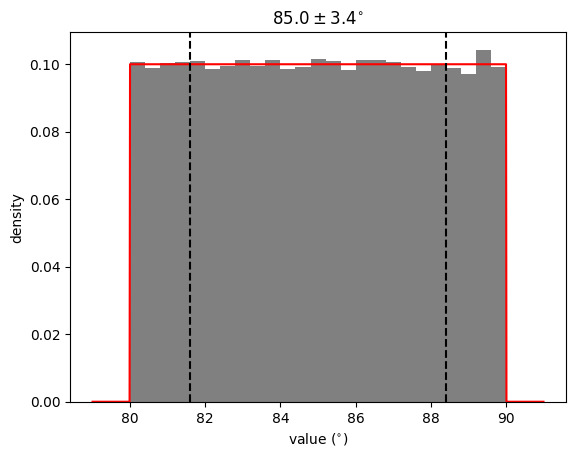

In [9]:
_ = bSystem['incl@distribution'].plot(show=True)

You can also see how different distributions correlate with each other (may not be useful now, but could be when creating multivariate distributions) using the `bSystem.get_distribution_collection` and `bSystem_plot.distribution_collection` functions.

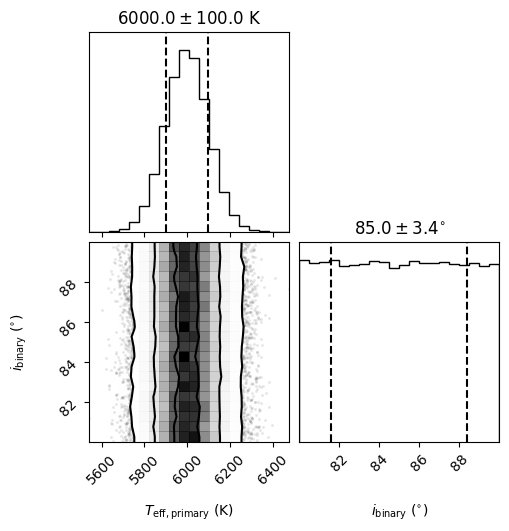

In [10]:
_ = bSystem.plot_distribution_collection(distribution='dist01', show=True)

But you can use `parameters` to either get a subset of the distribution, or to propagate the distributions through the constraints linking them together (if the parameters of the distribution link together, e.g. `sma` and `q` link to `asini`).

### Sampling Distributions

You can sample from these distributions by calling `bSystem.sample_distribution_collection`.

In [11]:
bSystem.sample_distribution_collection(distribution='dist01')

{'teff@primary@star@component': np.float64(5865.477811121084),
 'incl@binary@orbit@component': np.float64(87.44404667697897)}

This returns a dictionary with the twigs + sampled values, but you can also applied these immediately by passing `set_value=True`.

In [12]:
print(bSystem.sample_distribution_collection(distribution='dist01', set_value=True))

ParameterSet: 12 parameters
           teff@primary@component: 5928.770717738513 K
            incl@binary@component: 86.03689546236961 deg
C      teffratio@binary@component: 1.0120141738739152
C          asini@binary@component: 5.287326443478463 solRad
C         asini@primary@component: 2.6436632217392315 solRad
C          incl@primary@component: 86.03689546236961 deg
C    requiv_max@primary@component: 2.013275176537638 solRad
C       asini@secondary@component: 2.6436632217392315 solRad
C        incl@secondary@component: 86.03689546236961 deg
C  requiv_max@secondary@component: 2.013275176537638 solRad
C    requiv_max@primary@component: 2.013275176537638 solRad
C  requiv_max@secondary@component: 2.013275176537638 solRad


### Propagating it through the Forward Model

PHOEBE can be set to run a sample of forward models picking values from the distributions and compiling it into an average. In order to do this, you need to point `bSystem['sample_from']` to the distributions.

In [13]:
bSystem['sample_from'] = 'dist01'

In [14]:
print(bSystem['sample*'])

ParameterSet: 4 parameters
     sample_from@phoebe01@compute: ['dist01']
   sample_from_combine@phoebe0...: first
      sample_num@phoebe01@compute: 10
     sample_mode@phoebe01@compute: 1-sigma


According to the above, PHOEBE will run 10 different instances of the forward model from 10 different samples from the 'dist01' sample. After it, it will expose the median and 1-sigma uncertainties in the final model.

In [15]:
bSystem.run_compute(irrad_method='none')

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


<ParameterSet: 8 parameters | qualifiers: sample_mode, sampled_twigs, sampled_uniqueids, samples, comments, failed_samples, fluxes, times>

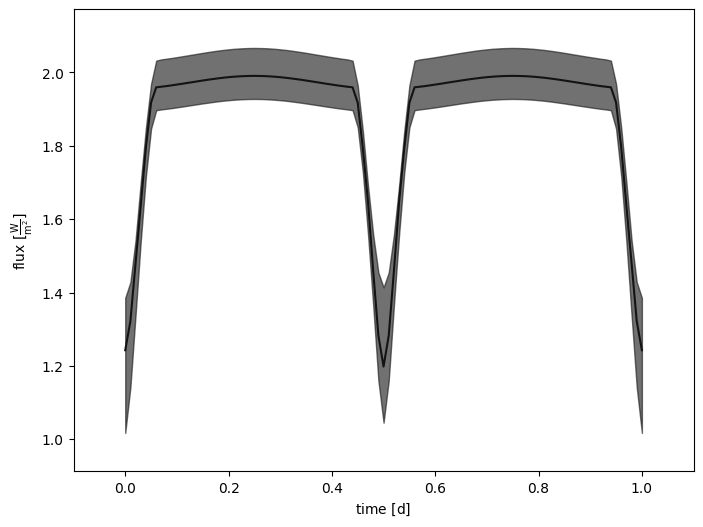

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [16]:
bSystem.plot(show=True)

### Accessing Uncertainties of Distribution Collections

The resulting uncertainties of distribution collections can be accessed by calling `bSystem.uncertainties_from_distribution_collection`.

In [19]:
print(bSystem.uncertainties_from_distribution_collection(distribution='dist01', tex=True))

teff@primary = 6000.0 +/- 100.0  K
 incl@binary = 85.0 +/- 3.4  deg



This does it at a "$1\sigma$-level" automatically. This can be changed by passing `sigma`.

Additionally, you can switch between human-readable and machine readable by including/excluding `tex=True`. This shows the lower, central and upper bounds for each parameter.

In [20]:
print(bSystem.uncertainties_from_distribution_collection(distribution='dist01'))

[[5900.0, 6000.0, 6100.0], array([81.58655254, 85.        , 88.41344746])]
